In [3]:
from pathlib import Path
import sys

# Ensure the NCAP repo root is on sys.path so connectome_priors is importable
PROJECT_ROOT = Path.cwd()
for candidate in [PROJECT_ROOT] + list(PROJECT_ROOT.parents):
    if (candidate / 'connectome_priors').exists() and (candidate / 'NMAP').exists():
        PROJECT_ROOT = candidate
        break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print('Project root:', PROJECT_ROOT)
print('In sys.path:', str(PROJECT_ROOT) in sys.path)
print('torch version:', __import__('torch').__version__)
import matplotlib

Project root: /home/amin/Research/NCAP/NMAP/connectome_priors
In sys.path: True
torch version: 2.8.0+cu128


# Sparse NCAP geometric priors sanity check

Loads Cook 2019 synapse counts (SI 5 spreadsheet) and c302 coordinates, computes sparse scalar pathway priors, and verifies the notebook penalty matches model penalty.



Inventory refresh warnings: []
Distance priors: {'ipsi_db': 0.6264940919089531, 'ipsi_vb': 0.6426412781776627, 'contra_db': 1.0, 'contra_vb': 0.642907538897161, 'next_db': 0.21138532543397495, 'next_vb': 0.13028824309396334}
Synapse priors: {'ipsi_db': 7.560975609756097, 'ipsi_vb': 7.75, 'contra_db': 1.8043956043956044, 'contra_vb': 1.651906975829718, 'next_db': 5.833333333333333, 'next_vb': 4.333333333333333}
Pathway counts: {'ipsi_db': 41, 'ipsi_vb': 20, 'contra_db': 5, 'contra_vb': 55, 'next_db': 6, 'next_vb': 9}
Translator examples: {'DB01': 'DB1', 'VB01': 'VB1', 'DD01': 'DD1', 'VD01': 'VD1', 'dBWML1': 'MDL01', 'vBWMR1': 'MVR01'}
Metadata: {'max_distance_mm_before_norm': 441.86996188034925, 'missing_pathways': []}
NCAP Swimmer using device: cuda
NCAP model on GPU: cuda:0
GPU memory after NCAP: 0.03 MB
TonicNCAPModel moved to device: cuda
Notebook sparse penalty: 0.078208
Model sparse penalty: 0.078208
Absolute diff: 0.000000e+00


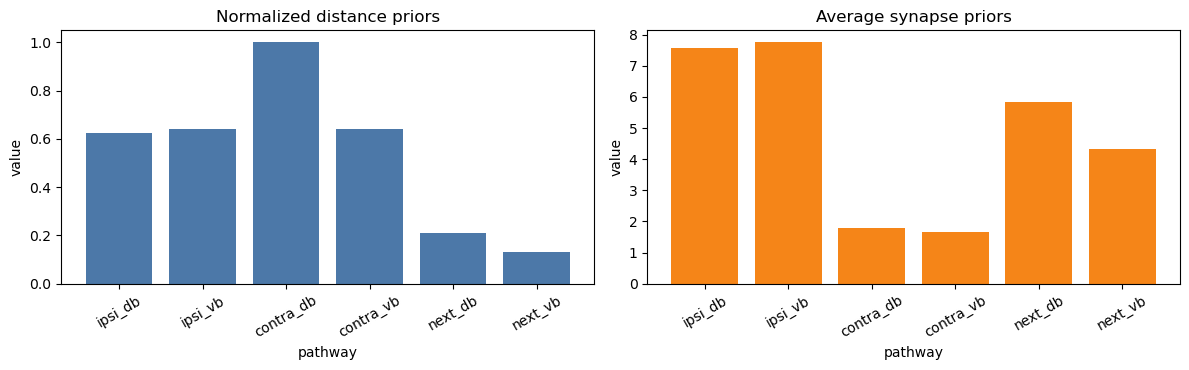

In [2]:
import torch
import matplotlib.pyplot as plt

from connectome_priors.swimmer_priors import generate_ncap_segment_priors, refresh_inventory_files
from NMAP.swimmer.models.tonic_ncap import create_tonic_ncap_model

n_joints = 6
num_segments = 10
prior_lambda = 0.01
pathways = ["ipsi_db", "ipsi_vb", "contra_db", "contra_vb", "next_db", "next_vb"]

metadata = refresh_inventory_files()
print("Inventory refresh warnings:", metadata.get("warnings", []))

priors = generate_ncap_segment_priors(num_segments=num_segments)
print("Distance priors:", {p: priors[f"dist_{p}"] for p in pathways})
print("Synapse priors:", {p: priors[f"syn_{p}"] for p in pathways})
print("Pathway counts:", {p: priors[f"count_{p}"] for p in pathways})
print("Translator examples:", priors["translator_examples"])
print("Metadata:", priors["metadata"])

model = create_tonic_ncap_model(
    n_joints=n_joints,
    num_segments=num_segments,
    prior_modulation_scale=0.15,
)

sparse = model.get_sparse_prior_scalars()

def pathway_l2(ncap_model, pathway):
    terms = []
    for name, param in ncap_model.ncap.params.items():
        if pathway == "ipsi_db":
            if name.startswith("muscle_d_d_") or name == "muscle_ipsi":
                terms.append((param ** 2).sum())
        elif pathway == "ipsi_vb":
            if name.startswith("muscle_v_v_") or name == "muscle_ipsi":
                terms.append((param ** 2).sum())
        elif pathway == "contra_db":
            if name.startswith("muscle_v_d_") or name == "muscle_contra":
                terms.append((param ** 2).sum())
        elif pathway == "contra_vb":
            if name.startswith("muscle_d_v_") or name == "muscle_contra":
                terms.append((param ** 2).sum())
        elif pathway == "next_db":
            if name.startswith("bneuron_d_prop_") or name == "bneuron_prop":
                terms.append((param ** 2).sum())
        elif pathway == "next_vb":
            if name.startswith("bneuron_v_prop_") or name == "bneuron_prop":
                terms.append((param ** 2).sum())
    if terms:
        return torch.stack(terms).sum()
    return torch.zeros((), device=next(ncap_model.parameters()).device)

loss_notebook = prior_lambda * sum(
    sparse[f"dist_{p}"] * pathway_l2(model, p) for p in pathways
)
loss_model = model.compute_topological_prior_loss(prior_lambda)

print(f"Notebook sparse penalty: {float(loss_notebook.detach().cpu()):.6f}")
print(f"Model sparse penalty: {float(loss_model.detach().cpu()):.6f}")
print(f"Absolute diff: {float((loss_notebook - loss_model).abs().detach().cpu()):.6e}")

fig, axes = plt.subplots(1, 2, figsize=(12, 3.8))
axes[0].bar(pathways, [sparse[f"dist_{p}"] for p in pathways], color="#4C78A8")
axes[0].set_title("Normalized distance priors")
axes[0].set_ylim(0, 1.05)
axes[0].tick_params(axis="x", rotation=30)

axes[1].bar(pathways, [sparse[f"syn_{p}"] for p in pathways], color="#F58518")
axes[1].set_title("Average synapse priors")
axes[1].tick_params(axis="x", rotation=30)

for ax in axes:
    ax.set_xlabel("pathway")
    ax.set_ylabel("value")
plt.tight_layout()
plt.show()

